In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json, torch, sys, optuna
from tqdm import tqdm
import time as time
import torch as T
from torch.utils.data import DataLoader
from sklearn import preprocessing
from pickle import dump

## following are for connecting to FEM code
sys.path.append('../../')
import KratosMultiphysics
from fem_interfaces.kratos.Kratos_Struct_Linear_Sudret_Truss import *

## neural network realated functions 
from neural_net.training import train_with_loader
from neural_net.data_utilities import loader_creation
from neural_net.networks import Net3

# For repeatability
np.random.seed(42)
torch.manual_seed(0)

# For working in both gpu and cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/rishith/PhD/Codes/fem_neural_network/env/femnn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/rishith/PhD/Codes/fem_neural_network/env/femnn/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


Predicting for the inputs 210000000000.0 232000000000.0 0.00092 0.00189 -52000.0 -52000.0 -54000.0 -36000.0 -65000.0 -44000.0
Calling derived class to run many simulations
 |  /           |
 ' /   __| _` | __|  _ \   __|
 . \  |   (   | |   (   |\__ \
_|\_\_|  \__,_|\__|\___/ ____/
           Multi-Physics 9.1."3"-a1319808505-Release-x86_64
Compiled with threading support.
Maximum number of threads: 2.
Importing    KratosStructuralMechanicsApplication 
    KRATOS   ___|  |                   |                   |
           \___ \  __|  __| |   |  __| __| |   |  __| _` | |
                 | |   |    |   | (    |   |   | |   (   | |
           _____/ \__|_|   \__,_|\___|\__|\__,_|_|  \__,_|_| MECHANICS
Initializing KratosStructuralMechanicsApplication...
[WARNING] ::[MechanicalSolver]:: : Settings contain no longer used setting, please remove it: "problem_domain_sub_model_part_list" 
[WARNING] ::[MechanicalSolver]:: : Settings contain no longer used setting, please remove it: "processes

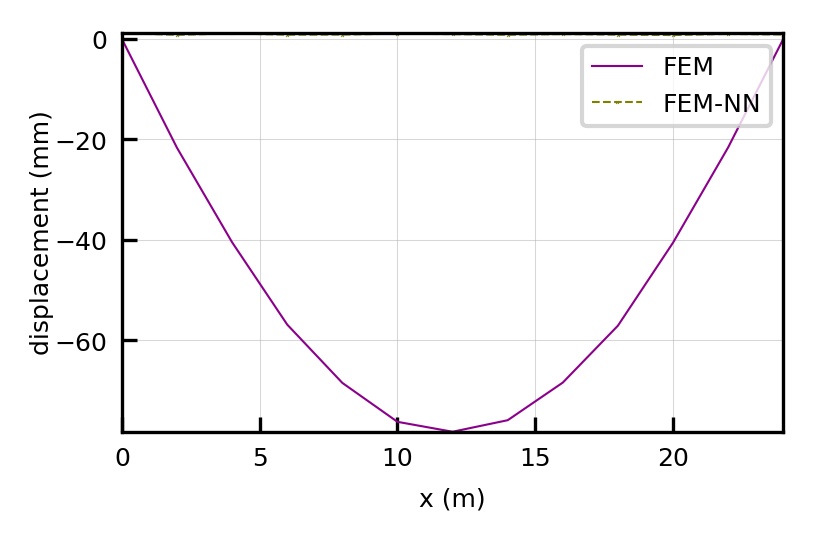

In [2]:
import numpy as np 
from matplotlib import pyplot as plt 
from scipy import stats 
from scipy import linalg 
from scipy.stats import gaussian_kde, tmean, tstd, skew, kurtosis, mode
import numpy as np
import json, sys, torch, pickle
from tqdm import tqdm 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## following are for connecting to FEM code
import KratosMultiphysics
sys.path.append('../../')
from fem_interfaces.kratos.Kratos_Struct_Linear_Sudret_Truss import *

from utilities.plot_utilities import plot_data_general 
from neural_net.networks import Net3
np.random.seed(25)

# material properties
E_Hor = 2.1e11
E_Ver = 2.32e11
A_Hor = 9.2e-4
A_Ver = 1.89e-3

# forces
P1 = -5.2e4
P2 = -5.2e4
P3 = -5.4e4
P4 = -3.6e4
P5 = -6.5e4
P6 = -4.4e4

print("Predicting for the inputs", E_Hor, E_Ver, A_Hor, A_Ver, P1, P2, P3, P4, P5, P6)

data_in_str  = np.array([[E_Ver, A_Ver, E_Hor, A_Hor]])
data_in_load = np.array([[P1, P2, P3, P4, P5, P6]])
data_in      = np.concatenate((data_in_str, data_in_load), axis=1)

scalar = pickle.load(open('scaler.pkl', 'rb'))

data_in_scaled = scalar.transform(data_in)
train_in = torch.from_numpy(data_in_scaled).float().to(device).requires_grad_(True)

### NN surrogate model
feature_size = data_in.shape[1] 

# creation of network
model = torch.load("model.pt")
# loading the parameters fram the saved model
model.eval()

pred = model(train_in)

with open("sim_parameters/ProjectParameters.json",'r') as parameter_file:
    parameters = KratosMultiphysics.Parameters(parameter_file.read())

for data_str, data_load in zip(data_in_str, data_in_load):  # replace it with all varible you wanto to change
    model_kratos = KratosMultiphysics.Model()
    # print(data_str)
    # print(data_load)
    # print('---------')
    simulation = StructMechAnaWithVaryingParameters_qoi(model_kratos, parameters, data_str, data_load)
    simulation.Run()
    # print(simulation.qoi_x)
    # print(simulation.qoi_y)
    # print(simulation.qoi_z)

    x_act = simulation.qoi_x
    y_act = simulation.qoi_y
    z_act = simulation.qoi_z

    # print(pred)
    # print(type(f),f.shape)
    # qoi_all.append(simulation.qoi)

pred_reshaped =  pred.reshape((13,3))
# print(pred_reshaped)

# plt.plot(x_act, label = "actual")
# plt.plot(pred_reshaped.detach().numpy()[:,0], label="predicted")

# plt.plot(y_act, label = "actual")
# plt.plot(pred_reshaped.detach().numpy()[:,1], label="predicted")

# # plt.plot(z_act, label= "Actual")
# # plt.plot(pred_reshaped.detach().numpy()[:,2], label = "Prediction")

# plt.legend()
# plt.show()
x_axis =  np.array([0, 2, 4, 6, 8, 10,  12, 14,  16, 18, 20, 22, 24])

# print(x_axis.shape)

plot_data_general(x_axis, np.asarray(y_act), pred_reshaped.detach().numpy()[:,1],"sudret",  ["FEM", "FEM-NN"],["x (m)", "displacement (mm)"])

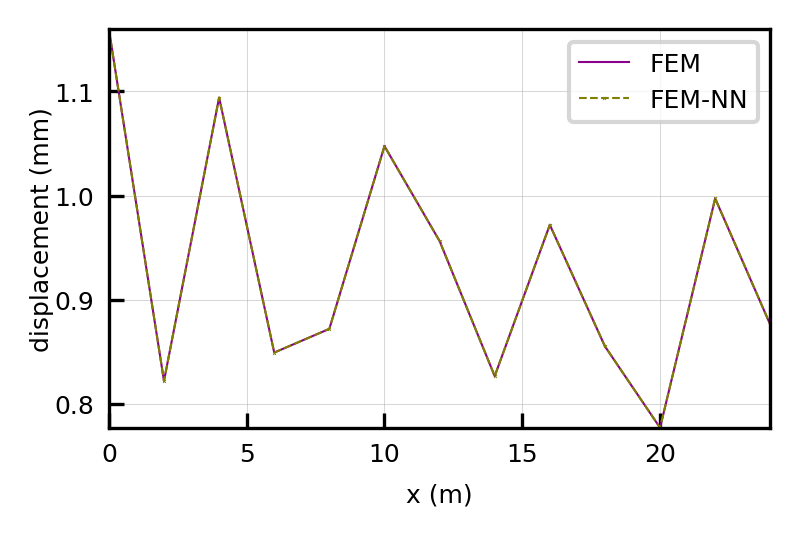

In [3]:
plot_data_general(x_axis, pred_reshaped.detach().numpy()[:,1], pred_reshaped.detach().numpy()[:,1], "sudret",  ["FEM", "FEM-NN"],["x (m)", "displacement (mm)"])

In [4]:
err

NameError: name 'err' is not defined

In [ ]:
# making training data of input space
n_samples = 15000

try:
    k_all = np.load(f'data/k_all_{n_samples}'+'.npy')
    f_all = np.load(f'data/f_all_{n_samples}'+'.npy')
    data_in = np.load(f'data/data_in_{n_samples}'+'.npy')
    loaded = True
except: 
    loaded = False

if not loaded:
    E_low = 2.1e11
    A_Ver_low = 2e-3
    A_Hor_low = 1e-3 
    F_low = -5e4

    E_high = 2.1e10
    A_Ver_high = 2e-4
    A_Hor_high = 1e-4
    F_high = 7.5e3

    E_Hor_rv = np.random.uniform(E_low,E_high, size = n_samples).reshape(n_samples,1)
    E_Ver_rv = np.random.uniform(E_low,E_high, size = n_samples).reshape(n_samples,1)
    A_Hor_rv = np.random.uniform(A_Hor_low,A_Hor_high, size = n_samples).reshape(n_samples,1)
    A_Ver_rv = np.random.uniform(A_Ver_low,A_Ver_high, size = n_samples).reshape(n_samples,1)
    F1_rv = np.random.uniform(F_low,F_high, size = n_samples).reshape(n_samples,1)
    F2_rv = np.random.uniform(F_low,F_high, size = n_samples).reshape(n_samples,1)
    F3_rv = np.random.uniform(F_low,F_high, size = n_samples).reshape(n_samples,1)
    F4_rv = np.random.uniform(F_low,F_high, size = n_samples).reshape(n_samples,1)
    F5_rv = np.random.uniform(F_low,F_high, size = n_samples).reshape(n_samples,1)
    F6_rv = np.random.uniform(F_low,F_high, size = n_samples).reshape(n_samples,1)

    data_in_str = np.concatenate((E_Ver_rv, A_Ver_rv, E_Hor_rv, A_Hor_rv), axis = 1)
    data_in_load = np.concatenate((F1_rv,F2_rv,F3_rv,F4_rv,F5_rv,F6_rv), axis = 1)
    data_in = np.concatenate((data_in_str, data_in_load), axis=1)
    k_all = []
    f_all = []

    ############ Data creation
    print("Started making data")
    with open("sim_parameters/ProjectParameters.json",'r') as parameter_file:
        parameters = KratosMultiphysics.Parameters(parameter_file.read())

    start_time = time.time()
    qoi_all = []

    ### call Kratos and create matrices  here
    for data_str, data_load in zip(data_in_str, data_in_load):  
        model = KratosMultiphysics.Model()
        simulation = StructMechAnaWithVaryingParameters(model,parameters,data_str, data_load)
        k, f  = simulation.Run()
        k_all.append(k)
        f_all.append(f)
    
    end_time = time.time()
    print("time taken to make data is", e-s)

    k_all = np.asarray(k_all)
    f_all = np.asarray(f_all)
    data_in = np.asarray(data_in)
        
    np.save(f'data/k_all_{n_samples}', k_all)
    np.save(f'data/f_all_{n_samples}', f_all)
    np.save(f'data/data_in_{n_samples}', data_in)

In [ ]:
scaler = preprocessing.MinMaxScaler()
data_in_s = scaler.fit_transform(data_in)
dump(scaler, open('scaler.pkl', 'wb'))

## data_in_s is the scaled input data to the neural network 
data_in_torch = torch.from_numpy(data_in_s).float().to(device)

## preprocessing of the data (only calculating averages of the matrix and vector used, more functionalities can be added)
pre = preprocess(data_in, k_all, f_all, n_samples)

## loader to load data in batches , batch size can be given in argument 
lc = loader_creation(data_in_torch, k_all, f_all, n_samples)
train_loader, test_loader = lc.get_loaders(16, True)
feature_size = data_in.shape[1]

def objective(trial):
    # Suggest values of the hyperparameters using a trial object.
    n_layers = trial.suggest_int('n_layers', 1, 20)
    n_units  = trial.suggest_int('n_units', 5, 500)
    init     =  trial.suggest_float("init", 10, 1000.0)
    lr       =  trial.suggest_float("lr", 0.0001, 100.0)

    # Creation of network
    net = Net3(n_feature = feature_size, n_hidden= n_units, n_output = 39, depth = n_layers, init = init )
    train_loss, test_loss = train_with_loader(net, train_loader, test_loader, lr, 3, plot = False)

    return train_loss

#Create a study object and optimize the objective function to find the best hyperparameters.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print(study.best_params["n_units"], study.best_params["n_layers"], study.best_params["init"], study.best_params["lr"])


In [ ]:
net_final = Net3(n_feature = feature_size, n_hidden= study.best_params["n_units"], n_output = 39, 
                depth = study.best_params["n_layers"], init = study.best_params["init"] )

train_loss, test_loss = train_with_loader(net_final, train_loader, test_loader, study.best_params["lr"], 250, plot = True)

In [ ]:
# saving the model
modelname = 'model'+'.pt'
torch.save(net_final, modelname)